In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_utils_state_save_parallel import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby

In [2]:
import networkx as nx
import igraph as ig
import itertools


# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환


# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    # 노드 매핑 (문자열 → 정수 변환)
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}

    # 엣지 및 가중치 추출
    edges = []
    weights = []
    for u, v, data in nx_graph.edges(data=True):
        edges.append((node_map[u], node_map[v]))  # 정수 인덱스로 변환된 엣지 추가
        weights.append(data['weight'])  # 가중치 추가

    # iGraph 객체 생성
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))  # 노드 추가
    ig_graph.add_edges(edges)  # 엣지 추가
    ig_graph.es['weight'] = weights  # 가중치 추가
    return ig_graph


# Canonical Form 생성
def canonical_form_with_weights(ig_graph):
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]  # 색상(label) 설정
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])  # canonical permutation
    permuted = ig_graph.permute_vertices(perm)  # 정렬 적용
    return tuple(map(tuple, permuted.get_adjacency().data))  # Immutable 변환


# 그래프 리스트 처리 및 중복 제거
def process_and_deduplicate(graph_list):
    canonical_set = set()  # 중복 제거를 위한 set
    for graph in graph_list:
        ig_graph = nx_to_igraph(graph)  # NetworkX → iGraph 변환
        canonical_form = canonical_form_with_weights(ig_graph)  # Canonical Form 생성
        canonical_set.add(canonical_form)  # 중복 제거
    return canonical_set

In [3]:
# EPM bipartite graph 생성
graph_list = EPM_bipartite_graph_generator_old(num_system=3, num_ancilla=1, type=0)

# 중복 제거된 canonical forms 추출
unique_graphs = process_and_deduplicate(graph_list)

# 결과 출력
print(f"Original graph count: {len(graph_list)}")
print(f"Unique graph count: {len(unique_graphs)}")


Original graph count: 3264
Unique graph count: 106


In [4]:
unique_graphs

{((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 1, 0, 1, 0, 0),
  (0, 0, 1, 0, 1, 0, 0, 0),
  (0, 0, 0, 1, 0, 1, 0, 0),
  (0, 0, 1, 0, 1, 0, 1, 1),
  (1, 1, 0, 0, 0, 1, 0, 0),
  (1, 1, 0, 0, 0, 1, 0, 0)),
 ((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 0, 0, 1, 0, 1),
  (0, 0, 0, 1, 1, 0, 0, 0),
  (0, 0, 1, 0, 0, 1, 0, 0),
  (0, 0, 1, 0, 0, 1, 1, 0),
  (0, 1, 0, 1, 1, 0, 0, 0),
  (1, 0, 0, 0, 1, 0, 0, 0),
  (1, 1, 0, 0, 0, 0, 0, 0)),
 ((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 0, 1, 0, 0, 1),
  (0, 0, 0, 1, 0, 1, 0, 0),
  (0, 0, 1, 0, 0, 0, 1, 0),
  (0, 1, 0, 0, 0, 1, 0, 0),
  (0, 0, 1, 0, 1, 0, 1, 1),
  (1, 0, 0, 1, 0, 1, 0, 0),
  (1, 1, 0, 0, 0, 1, 0, 0)),
 ((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 1, 0, 0, 0, 0, 1),
  (0, 1, 0, 0, 0, 1, 0, 0),
  (0, 0, 0, 0, 1, 0, 1, 0),
  (0, 0, 0, 1, 0, 1, 0, 0),
  (0, 0, 1, 0, 1, 0, 1, 1),
  (1, 0, 0, 1, 0, 1, 0, 0),
  (1, 1, 0, 0, 0, 1, 0, 0)),
 ((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 1, 0, 0, 1, 0, 0),
  (0, 1, 0, 0, 0, 0, 0, 1),
  (0, 0, 0, 0, 1

## 아래는 결과가 맞는지 확인하는 과정

In [5]:
import networkx as nx 
import igraph as ig
import itertools
from collections import defaultdict

# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환

# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}
    edges = []
    weights = []
    for u, v, data in nx_graph.edges(data=True):
        edges.append((node_map[u], node_map[v]))
        weights.append(data['weight'])
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))
    ig_graph.add_edges(edges)
    ig_graph.es['weight'] = weights
    return ig_graph

# Canonical Form 생성
def canonical_form_with_weights(ig_graph):
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])
    permuted = ig_graph.permute_vertices(perm)
    return tuple(map(tuple, permuted.get_adjacency().data))

# 그래프 리스트 처리 및 그룹화
def process_and_group(graph_list):
    groups = defaultdict(list)
    canonical_forms = {}
    grouped_graphs = defaultdict(list)

    for idx, graph in enumerate(graph_list):
        ig_graph = nx_to_igraph(graph)
        canonical_form = canonical_form_with_weights(ig_graph)

        if canonical_form not in canonical_forms:
            canonical_forms[canonical_form] = len(canonical_forms) + 1
        group_id = canonical_forms[canonical_form]
        groups[group_id].append(idx + 1)
        grouped_graphs[group_id].append(graph)  # 그래프 저장

    return groups, grouped_graphs

# 예제 실행
graphs = EPM_bipartite_graph_generator_old(3, 1, 0)
grouped_results, grouped_graphs = process_and_group(graphs)

print("Grouped Results:")
for group_id, members in grouped_results.items():
    print(f"Group {group_id}: {members}")


Grouped Results:
Group 1: [1, 5, 49, 53, 169, 181, 257, 269, 817, 821, 865, 869, 985, 997, 1073, 1085, 2177, 2189, 2265, 2277, 2393, 2397, 2441, 2445, 2993, 3005, 3081, 3093, 3209, 3213, 3257, 3261]
Group 2: [2, 6, 50, 54, 818, 822, 866, 870, 2178, 2190, 2266, 2278, 2994, 3006, 3082, 3094]
Group 3: [3, 7, 51, 55, 819, 823, 867, 871, 2179, 2191, 2267, 2279, 2995, 3007, 3083, 3095]
Group 4: [4, 8, 52, 56, 820, 824, 868, 872, 2180, 2192, 2268, 2280, 2996, 3008, 3084, 3096]
Group 5: [9, 19, 29, 35, 97, 107, 185, 191, 301, 303, 457, 459, 565, 567, 681, 683, 825, 835, 845, 851, 913, 923, 1001, 1007, 1661, 1663, 1817, 1819, 2469, 2471, 2585, 2587]
Group 6: [10, 20, 30, 36, 98, 108, 186, 192, 302, 304, 458, 460, 566, 568, 682, 684, 826, 836, 846, 852, 914, 924, 1002, 1008, 1662, 1664, 1818, 1820, 2470, 2472, 2586, 2588]
Group 7: [11, 21, 31, 37, 99, 109, 153, 157, 165, 177, 187, 193, 241, 245, 253, 265, 827, 837, 847, 853, 915, 925, 969, 973, 981, 993, 1003, 1009, 1057, 1061, 1069, 1081, 1129,

In [64]:
import networkx as nx 
import igraph as ig
import itertools
import numpy as np

# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환

# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    # 노드 매핑 (문자열 → 정수 변환)
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}
    edges = [(node_map[u], node_map[v], data['weight']) for u, v, data in nx_graph.edges(data=True)]

    # iGraph 객체 생성
    ig_graph = ig.Graph(directed=True)
    ig_graph.add_vertices(len(node_map))  # 정수 인덱스 기반 노드 추가
    ig_graph.add_edges([(u, v) for u, v, w in edges])  # 엣지 추가
    ig_graph.es['weight'] = [w for u, v, w in edges]  # 가중치 추가
    return ig_graph

# 가중치 기반 Canonical Form 생성
def weighted_canonical_form(ig_graph):
    adjacency = np.array(ig_graph.get_adjacency(attribute='weight').data)  # 가중치 행렬 추출
    return tuple(map(tuple, adjacency))  # immutable 변환

# 그래프 처리 및 중복 제거
def process_and_deduplicate(graph_list):
    canonical_forms = {}
    unique_graphs = []

    for graph in graph_list:
        # NetworkX -> iGraph 변환
        ig_graph = nx_to_igraph(graph)

        # Canonical form 생성
        canonical_form = weighted_canonical_form(ig_graph)

        # 중복 확인 및 저장
        if canonical_form not in canonical_forms:
            canonical_forms[canonical_form] = True
            unique_graphs.append(graph)  # 유일한 그래프만 추가

    return unique_graphs

# 예제 실행
graphs = EPM_bipartite_graph_generator_old(3, 1, 0)
unique_graphs = process_and_deduplicate(graphs)

print(f"Number of unique graphs: {len(unique_graphs)}")

Number of unique graphs: 3264


In [6]:
grouped_results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106])

In [57]:
nx.to_numpy_array(grouped_graphs[1][0], weight='weight')

array([[0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 0., 0., 3., 3.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 3., 0., 0., 0., 0.],
       [0., 0., 2., 3., 0., 0., 0., 0.]])

In [58]:
nx.to_numpy_array(grouped_graphs[1][3], weight='weight')

array([[0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 2., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 1.],
       [0., 0., 0., 0., 0., 0., 3., 3.],
       [1., 2., 0., 0., 0., 0., 0., 0.],
       [2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 3., 0., 0., 0., 0.],
       [0., 0., 1., 3., 0., 0., 0., 0.]])

In [ ]:
2
3
5
6
8
9
13
14
17
18
22
23
25
26
28
29

In [ ]:
canonical_form_with_weights(nx_to_igraph(grouped_graphs[1][0]))

In [70]:
import networkx as nx
import numpy as np
import igraph as ig

# NetworkX 그래프 생성
matrix1 = nx.to_numpy_array(grouped_graphs[1][0], weight='weight')
matrix2 = nx.to_numpy_array(grouped_graphs[1][3], weight='weight')

# G1 = grouped_graphs[1][0]
# G2 = grouped_graphs[1][3]

# iGraph 변환
def nx_to_igraph(G):
    edges = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]
    ig_graph = ig.Graph(directed=True)
    ig_graph.add_vertices(len(G.nodes))
    ig_graph.add_edges([(u, v) for u, v, w in edges])
    ig_graph.es['weight'] = [w for u, v, w in edges]
    return ig_graph

ig1 = nx_to_igraph(G1)
ig2 = nx_to_igraph(G2)

# 가중치 기반 canonical form 생성
def weighted_canonical_form(ig_graph):
    adjacency = np.array(ig_graph.get_adjacency(attribute='weight').data)  # 가중치 행렬 추출
    return tuple(map(tuple, adjacency))  # immutable 변환

canon1 = weighted_canonical_form(ig1)
canon2 = weighted_canonical_form(ig2)

# 결과 비교
print("Are the graphs isomorphic (weighted)?", canon1 == canon2)


AttributeError: 'numpy.ndarray' object has no attribute 'edges'

In [75]:
import networkx as nx
import numpy as np
import igraph as ig

matrix1 = nx.to_numpy_array(grouped_graphs[1][0], weight='weight')
matrix2 = nx.to_numpy_array(grouped_graphs[1][1], weight='weight')

# 이분 그래프 생성 함수
def create_bipartite_graph(matrix):
    B = nx.Graph()
    num_rows, num_cols = matrix.shape

    # 두 그룹으로 노드 구분
    group1 = range(num_rows // 2)  # 첫 번째 그룹
    group2 = range(num_rows // 2, num_rows)  # 두 번째 그룹

    # 노드 추가 및 속성 설정
    B.add_nodes_from(group1, bipartite=0)  # 첫 번째 그룹
    B.add_nodes_from(group2, bipartite=1)  # 두 번째 그룹

    # 엣지 추가
    for i in group1:
        for j in group2:
            weight = matrix[i, j]
            if weight > 0:  # 가중치가 있는 경우만 추가
                B.add_edge(i, j, weight=weight)

    return B

# 이분 그래프 생성
B1 = create_bipartite_graph(matrix1)
B2 = create_bipartite_graph(matrix2)

# NetworkX → iGraph 변환 함수
def nx_to_igraph(B):
    edges = [(u, v, data['weight']) for u, v, data in B.edges(data=True)]
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(B.nodes))
    ig_graph.add_edges([(u, v) for u, v, w in edges])
    ig_graph.es['weight'] = [w for u, v, w in edges]
    return ig_graph

ig1 = nx_to_igraph(B1)
ig2 = nx_to_igraph(B2)

# 가중치 기반 canonical form 생성 함수
def weighted_canonical_form(ig_graph):
    adjacency = np.array(ig_graph.get_adjacency(attribute='weight').data)  # 가중치 행렬 추출
    return tuple(map(tuple, adjacency))  # immutable 변환

# canonical form 생성
canon1 = weighted_canonical_form(ig1)
canon2 = weighted_canonical_form(ig2)

# 결과 비교
print("Are the bipartite graphs isomorphic (weighted)?", canon1 == canon2)


Are the bipartite graphs isomorphic (weighted)? False


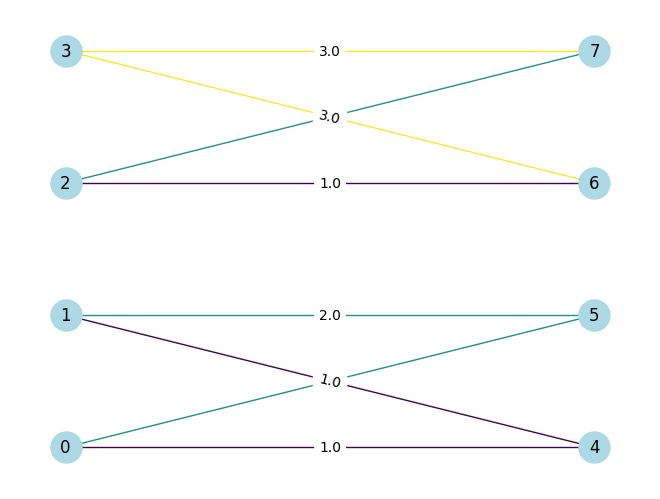

In [86]:
# 이분 그래프 생성
B1 = create_bipartite_graph(matrix1)

# 이분 그래프 그리기 함수
def draw_bipartite_graph(B):
    pos = nx.bipartite_layout(B, nodes=[n for n, d in B.nodes(data=True) if d['bipartite'] == 0])
    
    # 엣지 가중치에 따라 색상 매핑
    edges = B.edges(data=True)
    edge_colors = [data['weight'] for _, _, data in edges]

    # 그래프 그리기
    nx.draw(B, pos, with_labels=True, node_size=500, edge_color=edge_colors, edge_cmap=plt.cm.viridis, node_color='lightblue')

    # 가중치 표시
    edge_labels = nx.get_edge_attributes(B, 'weight')
    nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)

    plt.show()

# 그래프 그리기 실행
draw_bipartite_graph(B1)

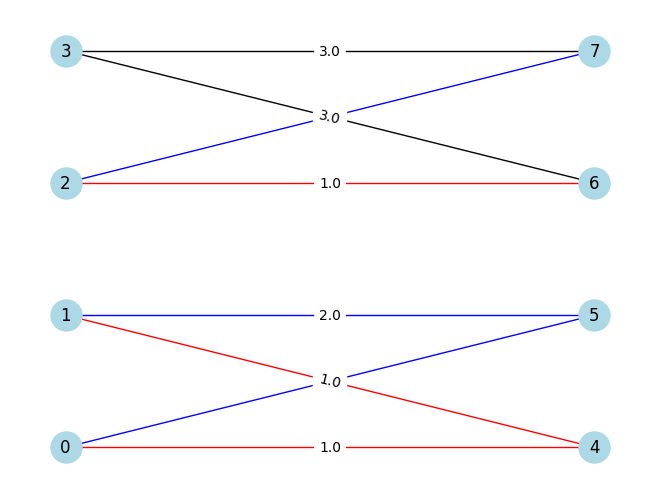

In [87]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

# 두 행렬 정의
matrix1 = np.array([[0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 1., 2.],
                    [0., 0., 0., 0., 0., 0., 3., 3.],
                    [1., 1., 0., 0., 0., 0., 0., 0.],
                    [2., 2., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 1., 3., 0., 0., 0., 0.],
                    [0., 0., 2., 3., 0., 0., 0., 0.]])


# 이분 그래프 생성 함수
def create_bipartite_graph(matrix):
    B = nx.Graph()
    num_rows, num_cols = matrix.shape

    # 두 그룹으로 노드 구분
    group1 = range(num_rows // 2)  # 첫 번째 그룹
    group2 = range(num_rows // 2, num_rows)  # 두 번째 그룹

    # 노드 추가 및 속성 설정
    B.add_nodes_from(group1, bipartite=0)  # 첫 번째 그룹
    B.add_nodes_from(group2, bipartite=1)  # 두 번째 그룹

    # 엣지 추가
    for i in group1:
        for j in group2:
            weight = matrix[i, j]
            if weight > 0:  # 가중치가 있는 경우만 추가
                B.add_edge(i, j, weight=weight)

    return B

# 이분 그래프 생성
B1 = create_bipartite_graph(matrix1)

# 이분 그래프 그리기 함수
def draw_bipartite_graph(B):
    pos = nx.bipartite_layout(B, nodes=[n for n, d in B.nodes(data=True) if d['bipartite'] == 0])
    
    # 엣지 색상 매핑
    edges = B.edges(data=True)
    edge_colors = []
    for _, _, data in edges:
        if data['weight'] == 1:
            edge_colors.append('red')
        elif data['weight'] == 2:
            edge_colors.append('blue')
        elif data['weight'] == 3:
            edge_colors.append('black')

    # 그래프 그리기
    nx.draw(B, pos, with_labels=True, node_size=500, edge_color=edge_colors, node_color='lightblue')

    # 가중치 표시
    edge_labels = nx.get_edge_attributes(B, 'weight')
    nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)

    plt.show()

# 그래프 그리기 실행
draw_bipartite_graph(B1)


In [ ]:
B2 = create_bipartite_graph(matrix2)

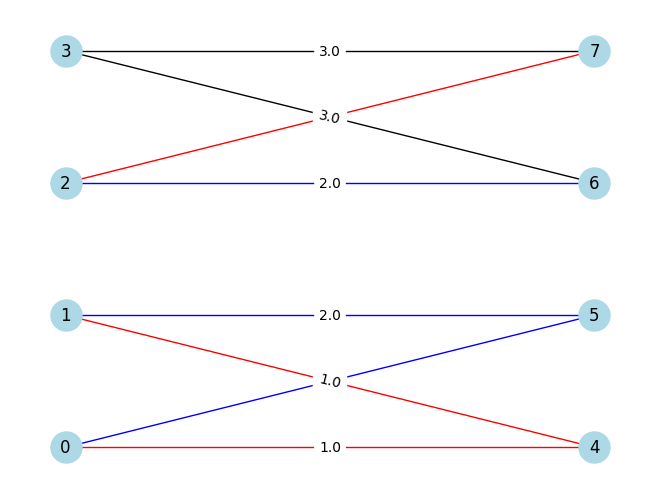

In [88]:
draw_bipartite_graph(B2)

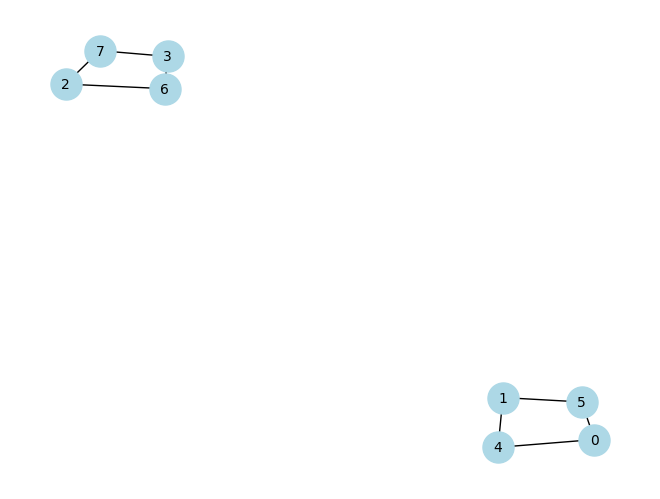

In [84]:
nx.draw(B1, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

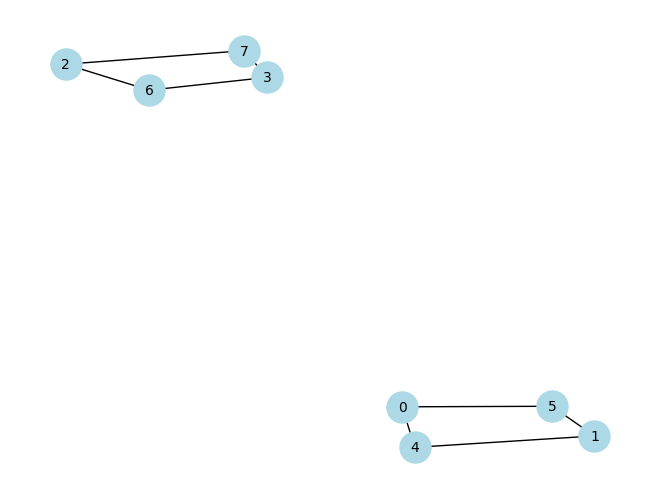

In [85]:
nx.draw(B2, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [77]:
matrix1 = nx.to_numpy_array(grouped_graphs[1][0], weight='weight')
matrix1

array([[0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 0., 0., 3., 3.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 3., 0., 0., 0., 0.],
       [0., 0., 2., 3., 0., 0., 0., 0.]])

In [78]:
matrix2 = nx.to_numpy_array(grouped_graphs[1][1], weight='weight')
matrix2

array([[0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 1.],
       [0., 0., 0., 0., 0., 0., 3., 3.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [2., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 3., 0., 0., 0., 0.],
       [0., 0., 1., 3., 0., 0., 0., 0.]])

In [ ]:
import networkx as nx
from collections import defaultdict
import pandas as pd
import itertools

# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = str(rb_index)

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = str(num_system + anc_index)

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = str(rb_index)

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환

# Nauty 기반 정규 라벨링 함수
def relabel_graph(graph):
    mapping = {node: str(idx) for idx, node in enumerate(sorted(graph.nodes(), key=str))}
    return nx.relabel_nodes(graph, mapping)

def canonical_labeling_nauty(graph):
    relabeled_graph = relabel_graph(graph)
    relabeled_edges = sorted((min(u, v), max(u, v), data['weight']) for u, v, data in relabeled_graph.edges(data=True))
    return tuple(relabeled_edges)

# 동형성 테스트 수행 함수
def isomorphic_test(forms):
    n = len(forms)
    result = defaultdict(list)
    for i in range(n):
        for j in range(i + 1, n):
            if forms[i] == forms[j]:
                result[i + 1].append(j + 1)
    return result

# EPM 그래프 생성 및 처리
num_system = 3
num_ancilla = 1
type = 0

epm_graphs = EPM_bipartite_graph_generator_old(num_system, num_ancilla, type)

# Nauty 기반 정규 라벨링 적용
canonical_forms_nauty = [canonical_labeling_nauty(g) for g in epm_graphs]
iso_test_nauty = isomorphic_test(canonical_forms_nauty)

# 결과 정리 및 출력
results = pd.DataFrame({
    'Graph Index': list(range(1, len(epm_graphs) + 1)),
    'Nauty Forms': [str(form) for form in canonical_forms_nauty]
})

print("Canonical Forms:")
print(results)

print("\nIsomorphic Groups:")
print(iso_test_nauty)

# # CSV 저장 (선택 사항)
# results.to_csv("canonical_results.csv", index=False)


Canonical Forms:
      Graph Index                                        Nauty Forms
0               1  (('0', '5', 1.0), ('0', '6', 1.0), ('1', '5', ...
1               2  (('0', '4', 3), ('0', '5', 1.0), ('0', '6', 1....
2               3  (('0', '5', 1.0), ('0', '6', 1.0), ('1', '4', ...
3               4  (('0', '4', 3), ('0', '5', 1.0), ('0', '6', 1....
4               5  (('0', '5', 1.0), ('0', '6', 1.0), ('1', '5', ...
...           ...                                                ...
3259         3260  (('0', '4', 3), ('0', '7', 1.0), ('1', '4', 3)...
3260         3261  (('0', '4', 3), ('0', '7', 2.0), ('1', '4', 3)...
3261         3262  (('0', '4', 3), ('0', '7', 2.0), ('1', '4', 3)...
3262         3263  (('0', '4', 3), ('0', '7', 2.0), ('1', '4', 3)...
3263         3264  (('0', '4', 3), ('0', '7', 2.0), ('1', '4', 3)...

[3264 rows x 2 columns]

Isomorphic Groups:
defaultdict(<class 'list'>, {})


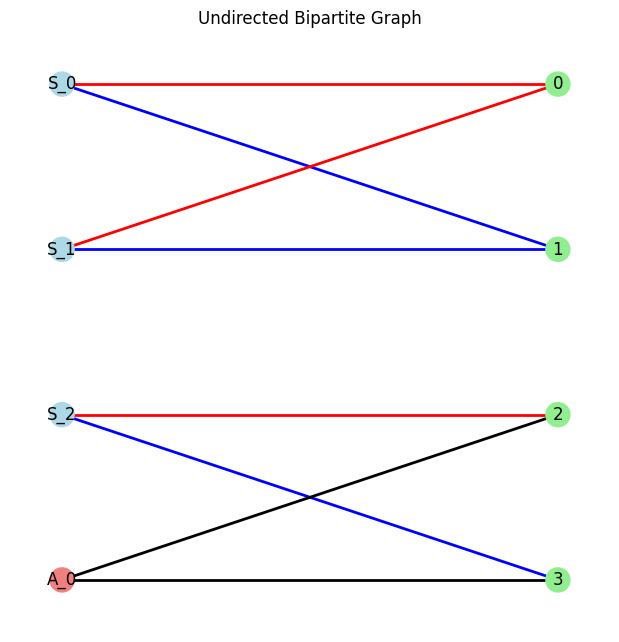

In [80]:
Draw_EPM_bipartite_graph(grouped_graphs[1][0])

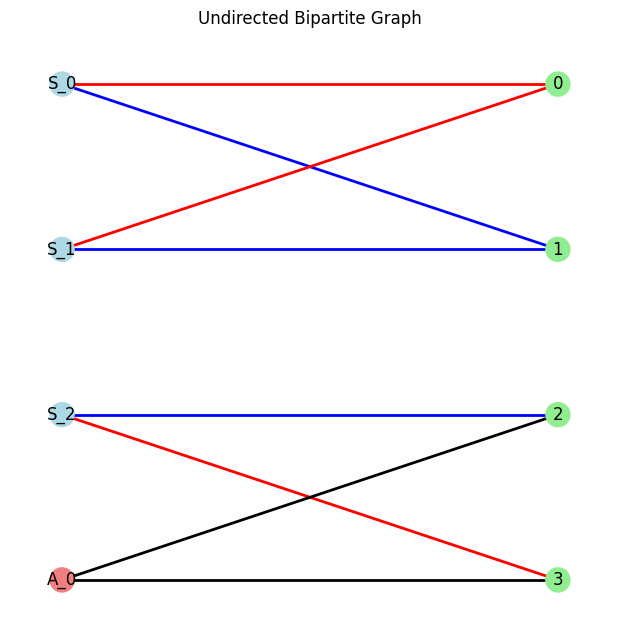

In [79]:
Draw_EPM_bipartite_graph(grouped_graphs[1][1])

In [48]:
canonical_form_with_weights(nx_to_igraph(grouped_graphs[1][0]))

((0, 0, 0, 0, 0, 0, 1, 1),
 (0, 0, 1, 0, 1, 0, 0, 0),
 (0, 1, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 0, 0, 1, 1),
 (0, 1, 0, 0, 0, 1, 0, 0),
 (0, 0, 1, 0, 1, 0, 0, 0),
 (1, 0, 0, 1, 0, 0, 0, 0),
 (1, 0, 0, 1, 0, 0, 0, 0))

In [49]:
canonical_form_with_weights(nx_to_igraph(grouped_graphs[1][3]))

((0, 0, 0, 0, 0, 0, 1, 1),
 (0, 0, 1, 0, 1, 0, 0, 0),
 (0, 1, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 0, 0, 1, 1),
 (0, 1, 0, 0, 0, 1, 0, 0),
 (0, 0, 1, 0, 1, 0, 0, 0),
 (1, 0, 0, 1, 0, 0, 0, 0),
 (1, 0, 0, 1, 0, 0, 0, 0))

In [50]:
canonical_form_with_weights(nx_to_igraph(grouped_graphs[1][0])) == canonical_form_with_weights(nx_to_igraph(grouped_graphs[1][3]))

True

In [10]:
grouped_graphs[1]

for i in grouped_graphs[3]:
    if not nx.is_isomorphic(grouped_graphs[3][0], i):
        print("not isomorphic")

In [11]:
len(grouped_graphs)

106

In [12]:
grouped_graphs.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106])

In [21]:
grouped_graphs[1][0]

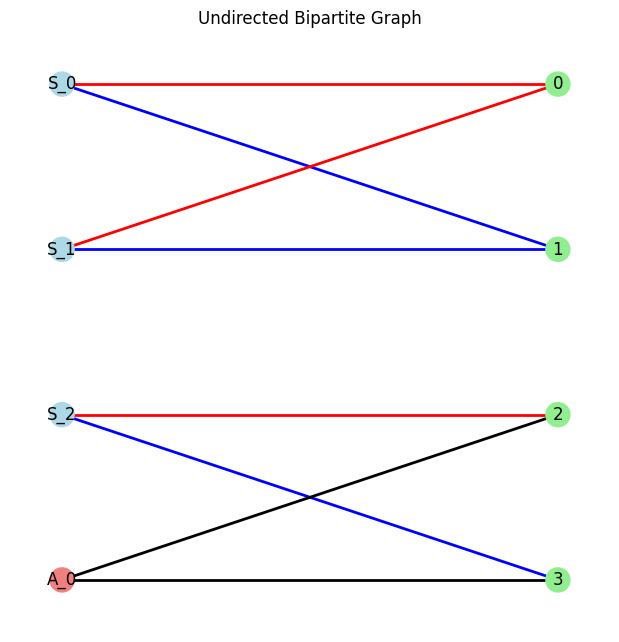

In [26]:
Draw_EPM_bipartite_graph(grouped_graphs[1][0])

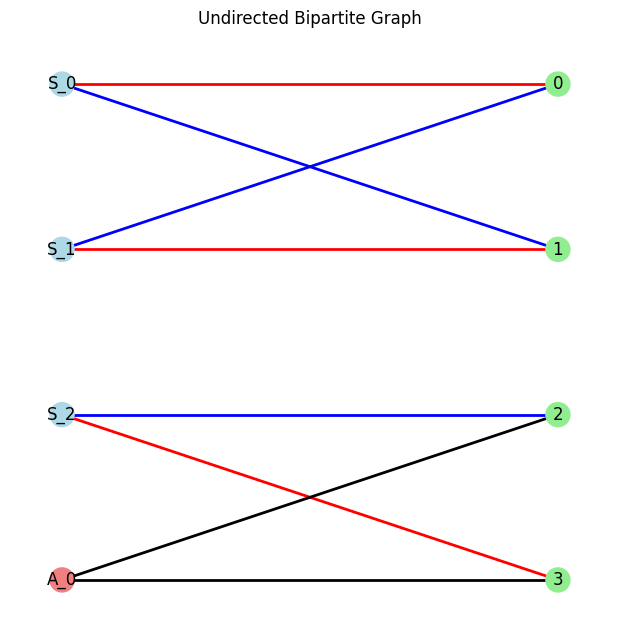

In [42]:
Draw_EPM_bipartite_graph(grouped_graphs[1][3])

In [81]:
nx.is_isomorphic(grouped_graphs[1][0], grouped_graphs[1][1], edge_match=edge_match)  # 가중치 고려 검사

True

In [89]:
nx.is_isomorphic(grouped_graphs[1][0], grouped_graphs[1][1], edge_match=edge_match)  # 가중치 고려 검사

True

In [90]:
import networkx as nx
import numpy as np
import igraph as ig

# 두 행렬 정의
matrix1 = np.array([[0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 1., 2.],
                    [0., 0., 0., 0., 0., 0., 3., 3.],
                    [1., 1., 0., 0., 0., 0., 0., 0.],
                    [2., 2., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 1., 3., 0., 0., 0., 0.],
                    [0., 0., 2., 3., 0., 0., 0., 0.]])

matrix2 = np.array([[0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 2., 1.],
                    [0., 0., 0., 0., 0., 0., 3., 3.],
                    [1., 1., 0., 0., 0., 0., 0., 0.],
                    [2., 2., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 2., 3., 0., 0., 0., 0.],
                    [0., 0., 1., 3., 0., 0., 0., 0.]])

# 이분 그래프 생성 함수
def create_bipartite_graph(matrix):
    B = nx.Graph()
    num_rows, num_cols = matrix.shape

    group1 = range(num_rows // 2)  # 첫 번째 그룹
    group2 = range(num_rows // 2, num_rows)  # 두 번째 그룹

    B.add_nodes_from(group1, bipartite=0)
    B.add_nodes_from(group2, bipartite=1)

    for i in group1:
        for j in group2:
            weight = matrix[i, j]
            if weight > 0:
                B.add_edge(i, j, weight=weight)

    return B

# 그래프 생성
B1 = create_bipartite_graph(matrix1)
B2 = create_bipartite_graph(matrix2)

# iGraph 변환
def nx_to_igraph(B):
    edges = [(u, v, data['weight']) for u, v, data in B.edges(data=True)]
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(B.nodes))
    ig_graph.add_edges([(u, v) for u, v, w in edges])
    ig_graph.es['weight'] = [w for u, v, w in edges]
    return ig_graph

ig1 = nx_to_igraph(B1)
ig2 = nx_to_igraph(B2)

# canonical labeling 기반 검사
def weighted_canonical_form(ig_graph):
    adjacency = np.array(ig_graph.get_adjacency(attribute='weight').data)
    return tuple(map(tuple, adjacency))

canon1 = weighted_canonical_form(ig1)
canon2 = weighted_canonical_form(ig2)

# 결과 비교
print("Are the bipartite graphs isomorphic (weighted)?", canon1 == canon2)


Are the bipartite graphs isomorphic (weighted)? False


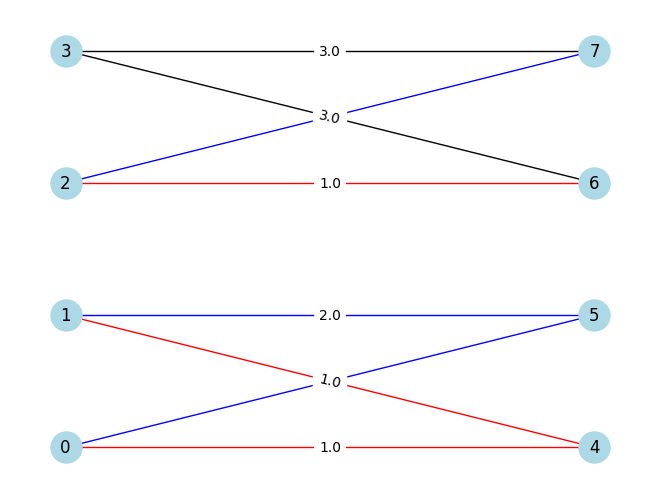

In [91]:
draw_bipartite_graph(B1)

In [93]:
import networkx as nx
import numpy as np

# 행렬 정의
matrix1 = np.array([[0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 1., 2.],
                    [0., 0., 0., 0., 0., 0., 3., 3.],
                    [1., 1., 0., 0., 0., 0., 0., 0.],
                    [2., 2., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 1., 3., 0., 0., 0., 0.],
                    [0., 0., 2., 3., 0., 0., 0., 0.]])

matrix2 = np.array([[0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 2., 1.],
                    [0., 0., 0., 0., 0., 0., 3., 3.],
                    [1., 1., 0., 0., 0., 0., 0., 0.],
                    [2., 2., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 2., 3., 0., 0., 0., 0.],
                    [0., 0., 1., 3., 0., 0., 0., 0.]])

# 그래프 생성
G1 = nx.from_numpy_array(matrix1)
G2 = nx.from_numpy_array(matrix2)

# 가중치 비교 함수
edge_match = nx.algorithms.isomorphism.numerical_edge_match('weight', 1.0)

# 동형성 검사
print("Are the graphs isomorphic (weighted)?", nx.is_isomorphic(G1, G2, edge_match=edge_match))


Are the graphs isomorphic (weighted)? True


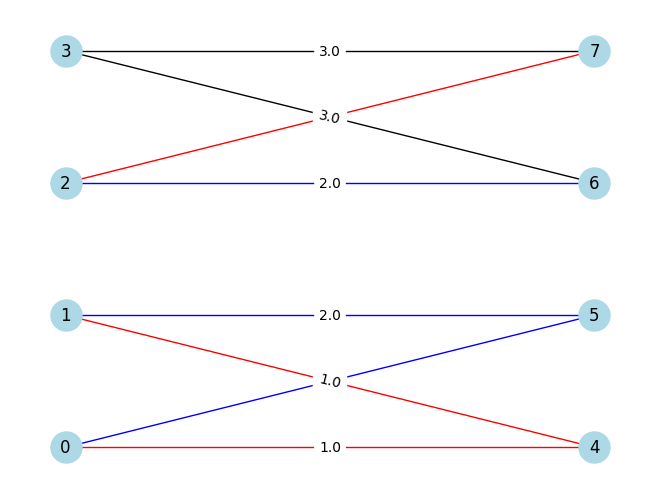

In [92]:
draw_bipartite_graph(B2)

In [104]:
import networkx as nx
import numpy as np
import igraph as ig

# 두 행렬 정의
matrix1 = np.array([[0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 1., 2.],
                    [0., 0., 0., 0., 0., 0., 3., 3.],
                    [1., 1., 0., 0., 0., 0., 0., 0.],
                    [2., 2., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 1., 3., 0., 0., 0., 0.],
                    [0., 0., 2., 3., 0., 0., 0., 0.]])

matrix2 = np.array([[0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 1., 2., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 2., 1.],
                    [0., 0., 0., 0., 0., 0., 3., 3.],
                    [1., 1., 0., 0., 0., 0., 0., 0.],
                    [2., 2., 0., 0., 0., 0., 0., 0.],
                    [0., 0., 2., 3., 0., 0., 0., 0.],
                    [0., 0., 1., 3., 0., 0., 0., 0.]])

# 이분 그래프 생성 함수
def create_bipartite_graph(matrix):
    B = nx.Graph()
    num_rows, num_cols = matrix.shape

    group1 = range(num_rows // 2)
    group2 = range(num_rows // 2, num_rows)

    B.add_nodes_from(group1, bipartite=0)
    B.add_nodes_from(group2, bipartite=1)

    for i in group1:
        for j in group2:
            weight = matrix[i, j]
            if weight > 0:
                B.add_edge(i, j, weight=weight)
    return B

# NetworkX -> iGraph 변환
def nx_to_igraph(B):
    edges = [(u, v, data['weight']) for u, v, data in B.edges(data=True)]
    ig_graph = ig.Graph(directed=False)
    ig_graph.add_vertices(len(B.nodes))
    ig_graph.add_edges([(u, v) for u, v, w in edges])
    ig_graph.es['weight'] = [w for u, v, w in edges]
    return ig_graph

# Canonical labeling 생성
def canonical_labeling_with_weights(ig_graph):
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]  # 가중치로 색상 설정
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])
    permuted = ig_graph.permute_vertices(perm)

    # 정규화된 adjacency matrix
    adjacency = np.array(permuted.get_adjacency(attribute='weight').data)
    # 가중치와 구조를 튜플로 변환 (순서 무관 비교 허용)
    return tuple(sorted(map(tuple, adjacency)))

# 그래프 생성
B1 = create_bipartite_graph(matrix1)
B2 = create_bipartite_graph(matrix2)

# iGraph 변환
ig1 = nx_to_igraph(B1)
ig2 = nx_to_igraph(B2)

# Canonical Form 생성
canon1 = canonical_labeling_with_weights(ig1)
canon2 = canonical_labeling_with_weights(ig2)

# 결과 비교
print("Canonical Forms Match (weighted, order-independent)?", canon1 == canon2)


Canonical Forms Match (weighted, order-independent)? False


In [101]:
# 동형성 검사
print("Are the graphs isomorphic (weighted)?", nx.is_isomorphic(B1, B2, edge_match=edge_match))

Are the graphs isomorphic (weighted)? True


In [40]:
base_graph = grouped_graphs[1][0]  # 기준 그래프
for k, j in enumerate(grouped_graphs[1]):
    if not nx.is_isomorphic(base_graph, j, edge_match=edge_match):  # 가중치 고려 검사
        print(k)


2
3
5
6
8
9
13
14
17
18
22
23
25
26
28
29


In [32]:
grouped_graphs[1]

In [14]:
import networkx as nx
from networkx.algorithms import isomorphism

# 간선 속성 비교 함수
edge_match = isomorphism.numerical_edge_match("weight", 0)

# 가중치 포함 isomorphism 검사
for i in list(grouped_graphs.keys()):
    base_graph = grouped_graphs[i][0]  # 기준 그래프
    for j in grouped_graphs[i]:
        if not nx.is_isomorphic(base_graph, j, edge_match=edge_match):  # 가중치 고려 검사
            print("not isomorphic", i)


not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 1
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 2
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 3
not isomorphic 4
not isomorphic 4
not isomorphic 4
not isomorphic 4
not isomorphic 4
not isomorphic 4
not isomorphic 4
not isomorphic 4
not isomorphic 5
not isomorphic 5
not isomorphic 5
not isomorphic 5
not isomorphic 5
not isomorphic 5
not isomorphic 5
not isomorphic 5
not isomorphic 5
not isomorphic 5
not isomorphic

In [17]:
import networkx as nx 
import igraph as ig
import itertools
from collections import defaultdict

# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환

# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}
    edges = []
    weights = []
    for u, v, data in nx_graph.edges(data=True):
        edges.append((node_map[u], node_map[v]))
        weights.append(data['weight'])
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))
    ig_graph.add_edges(edges)
    ig_graph.es['weight'] = weights
    return ig_graph

# Canonical Form 생성
def canonical_form_with_weights(ig_graph):
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])
    permuted = ig_graph.permute_vertices(perm)
    return tuple(map(tuple, permuted.get_adjacency().data))

# 그래프 리스트 처리 및 중복 제거
def process_and_deduplicate(graph_list):
    canonical_forms = {}
    unique_graphs = []

    for graph in graph_list:
        ig_graph = nx_to_igraph(graph)
        canonical_form = canonical_form_with_weights(ig_graph)

        if canonical_form not in canonical_forms:
            canonical_forms[canonical_form] = True
            unique_graphs.append(graph)  # 유일한 그래프만 추가

    return unique_graphs

# 예제 실행
graphs = EPM_bipartite_graph_generator_old(3, 1, 0)
unique_graphs = process_and_deduplicate(graphs)

print(f"Number of unique graphs: {len(unique_graphs)}")


Number of unique graphs: 106


In [20]:
unique_graphs

In [22]:
# adj_matrix = nx.adjacency_matrix(G).todense()

In [23]:
# weight_matrix = nx.to_numpy_array(G, weight='weight')  # 가중치 포함 행렬 생성

In [24]:
import networkx as nx

# bipartite 그래프를 directed graph로 변환

def EPM_digraph_from_EPM_bipartite_graph(B):
    # Directed graph 초기화
    D = nx.DiGraph()

    # 시스템 및 앙실라 노드 구분
    system_nodes = [node for node in list(B.nodes) if B.nodes[node]['category'] == 'system_nodes']
    ancilla_nodes = [node for node in list(B.nodes) if B.nodes[node]['category'] == 'ancilla_nodes']

    # 노드 개수 설정
    num_system = len(system_nodes)
    num_ancilla = len(ancilla_nodes)
    num_total = num_system + num_ancilla

    # 가중치 기반 엣지 추가
    for u, v, data in B.edges(data=True):
        if B.nodes[u]['category'] == 'system_nodes' or B.nodes[u]['category'] == 'ancilla_nodes':
            D.add_edge(v, u, weight=data['weight'])  # 방향 반대로 추가

    # 노드 매핑 및 속성 설정
    mapping = {}
    for i in range(num_total):
        if i < num_system:
            mapping[i] = 'S_' + str(i)
            D.nodes[i]['category'] = 'system_nodes'
        else:
            mapping[i] = 'A_' + str(i - num_system)
            D.nodes[i]['category'] = 'ancilla_nodes'

    # 노드 이름 재배열
    D = nx.relabel_nodes(D, mapping)

    return D


In [26]:
test_scc = []

for i in unique_graphs:
    digraph = EPM_digraph_from_EPM_bipartite_graph(i)
    if is_single_scc(digraph):
        test_scc.append((i, digraph))

In [29]:
len(test_scc)

98

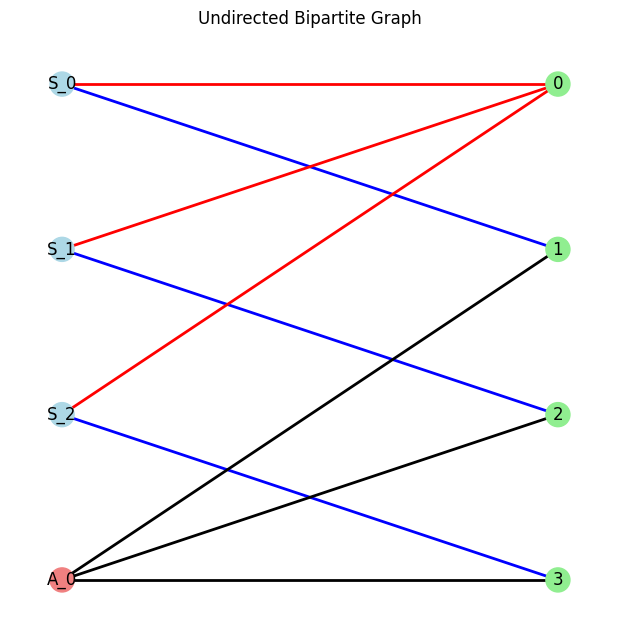

In [32]:
Draw_EPM_bipartite_graph(test_scc[0][0])

In [58]:
import networkx as nx
from itertools import combinations
from networkx.algorithms import isomorphism

# 그래프 리스트 예시
graph_list = unique_graphs

# 간선 속성 비교 함수
edge_match = isomorphism.numerical_edge_match("weight", 0)

# 서로 isomorphic한 그래프 쌍 찾기
isomorphic_pairs = []
for g1, g2 in combinations(enumerate(graph_list), 2):
    idx1, graph1 = g1
    idx2, graph2 = g2
    
    # 가중치까지 고려한 isomorphism 검사
    if nx.is_isomorphic(graph1, graph2, edge_match=edge_match):
        isomorphic_pairs.append((idx1, idx2))

# 결과 출력
if isomorphic_pairs:
    print("Isomorphic Graph Pairs:")
    for pair in isomorphic_pairs:
        print(f"Graph {pair[0]} and Graph {pair[1]} are isomorphic.")
else:
    print("No isomorphic graph pairs found.")

Isomorphic Graph Pairs:
Graph 0 and Graph 23 are isomorphic.
Graph 0 and Graph 45 are isomorphic.
Graph 0 and Graph 66 are isomorphic.
Graph 0 and Graph 96 are isomorphic.
Graph 0 and Graph 103 are isomorphic.
Graph 1 and Graph 24 are isomorphic.
Graph 1 and Graph 33 are isomorphic.
Graph 1 and Graph 46 are isomorphic.
Graph 1 and Graph 67 are isomorphic.
Graph 1 and Graph 73 are isomorphic.
Graph 1 and Graph 97 are isomorphic.
Graph 1 and Graph 104 are isomorphic.
Graph 2 and Graph 25 are isomorphic.
Graph 2 and Graph 47 are isomorphic.
Graph 2 and Graph 68 are isomorphic.
Graph 2 and Graph 74 are isomorphic.
Graph 2 and Graph 98 are isomorphic.
Graph 3 and Graph 26 are isomorphic.
Graph 3 and Graph 34 are isomorphic.
Graph 3 and Graph 48 are isomorphic.
Graph 3 and Graph 69 are isomorphic.
Graph 3 and Graph 75 are isomorphic.
Graph 3 and Graph 99 are isomorphic.
Graph 3 and Graph 105 are isomorphic.
Graph 4 and Graph 35 are isomorphic.
Graph 5 and Graph 36 are isomorphic.
Graph 6 and

In [59]:
isomorphic_pairs

[(0, 23),
 (0, 45),
 (0, 66),
 (0, 96),
 (0, 103),
 (1, 24),
 (1, 33),
 (1, 46),
 (1, 67),
 (1, 73),
 (1, 97),
 (1, 104),
 (2, 25),
 (2, 47),
 (2, 68),
 (2, 74),
 (2, 98),
 (3, 26),
 (3, 34),
 (3, 48),
 (3, 69),
 (3, 75),
 (3, 99),
 (3, 105),
 (4, 35),
 (5, 36),
 (6, 10),
 (6, 14),
 (6, 37),
 (6, 41),
 (7, 11),
 (7, 15),
 (7, 27),
 (7, 38),
 (7, 42),
 (8, 12),
 (8, 16),
 (8, 28),
 (8, 39),
 (8, 43),
 (9, 13),
 (9, 17),
 (9, 29),
 (9, 40),
 (9, 44),
 (10, 14),
 (10, 37),
 (10, 41),
 (11, 15),
 (11, 27),
 (11, 38),
 (11, 42),
 (12, 16),
 (12, 28),
 (12, 39),
 (12, 43),
 (13, 17),
 (13, 29),
 (13, 40),
 (13, 44),
 (14, 37),
 (14, 41),
 (15, 27),
 (15, 38),
 (15, 42),
 (16, 28),
 (16, 39),
 (16, 43),
 (17, 29),
 (17, 40),
 (17, 44),
 (18, 84),
 (19, 85),
 (20, 30),
 (20, 87),
 (21, 31),
 (21, 88),
 (22, 32),
 (22, 89),
 (23, 45),
 (23, 66),
 (23, 96),
 (23, 103),
 (24, 33),
 (24, 46),
 (24, 67),
 (24, 73),
 (24, 97),
 (24, 104),
 (25, 47),
 (25, 68),
 (25, 74),
 (25, 98),
 (26, 34),
 (26, 

In [36]:
import networkx as nx

# 그래프 리스트 예제 (가중치 포함)
graph_list = unique_graphs

# Edge 속성 일치 함수
def edge_match(e1, e2):
    return e1["weight"] == e2["weight"]

# Isomorphic 그룹화
groups = []
visited = [False] * len(graph_list)

for i in range(len(graph_list)):
    if visited[i]:
        continue
    group = [i]  # 현재 노드를 새로운 그룹에 추가
    for j in range(i + 1, len(graph_list)):
        if not visited[j] and nx.is_isomorphic(graph_list[i], graph_list[j], edge_match=edge_match):
            group.append(j)
            visited[j] = True
    visited[i] = True
    groups.append(group)

# 결과 출력
for idx, group in enumerate(groups):
    print(f"Group {idx + 1}: Graphs {group}")


Group 1: Graphs [0, 23, 45, 66, 96, 103]
Group 2: Graphs [1, 24, 33, 46, 67, 73, 97, 104]
Group 3: Graphs [2, 25, 47, 68, 74, 98]
Group 4: Graphs [3, 26, 34, 48, 69, 75, 99, 105]
Group 5: Graphs [4, 35]
Group 6: Graphs [5, 36]
Group 7: Graphs [6, 10, 14, 37, 41]
Group 8: Graphs [7, 11, 15, 27, 38, 42]
Group 9: Graphs [8, 12, 16, 28, 39, 43]
Group 10: Graphs [9, 13, 17, 29, 40, 44]
Group 11: Graphs [18, 84]
Group 12: Graphs [19, 85]
Group 13: Graphs [20, 30, 87]
Group 14: Graphs [21, 31, 88]
Group 15: Graphs [22, 32, 89]
Group 16: Graphs [49, 53, 57, 90]
Group 17: Graphs [50, 54, 58, 61, 70, 91]
Group 18: Graphs [51, 55, 59, 62, 71, 92]
Group 19: Graphs [52, 56, 60, 63, 72, 93]
Group 20: Graphs [64, 79, 94]
Group 21: Graphs [65, 80, 95]
Group 22: Graphs [76, 81, 100]
Group 23: Graphs [77, 82, 101]
Group 24: Graphs [78, 83, 102]
Group 25: Graphs [86]


In [43]:
# Isomorphic 그룹화
groups = []
visited = [False] * len(graph_list)

# Isomorphic 그룹화
groups = []
visited = [False] * len(graph_list)

for i in range(len(graph_list)):
    if visited[i]:
        continue
    # 현재 그래프와 번호 매칭
    group = [(i, graph_list[i])]
    for j in range(i + 1, len(graph_list)):
        if not visited[j] and nx.is_isomorphic(graph_list[i], graph_list[j]):
            group.append((j, graph_list[j]))
            visited[j] = True
    visited[i] = True
    groups.append(group)

In [55]:
groups[0][0]

(0, <networkx.classes.graph.Graph at 0x7ff56db31ab0>)

In [56]:
groups[0][1]

(23, <networkx.classes.graph.Graph at 0x7ff56d76ff40>)

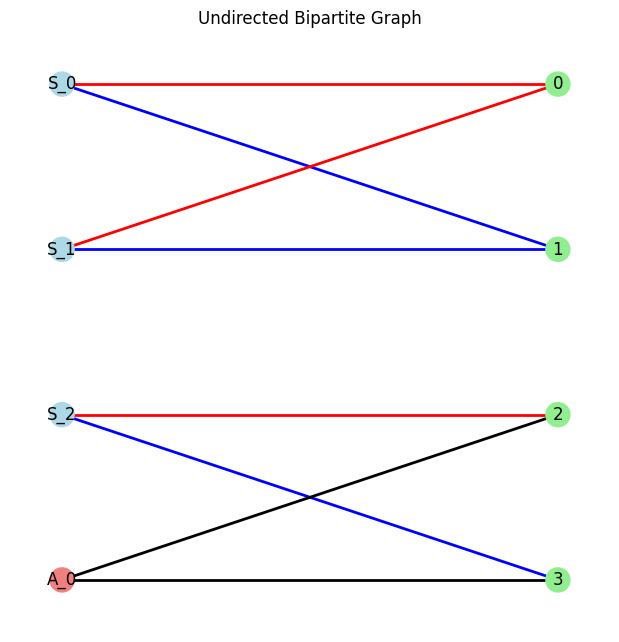

In [49]:
groups[0][0][1]
Draw_EPM_bipartite_graph(groups[0][0][1])

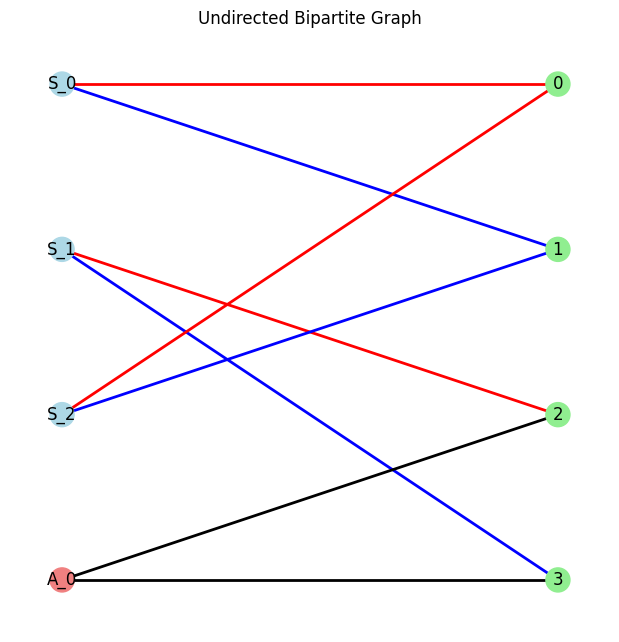

In [57]:
groups[0][1][1]
Draw_EPM_bipartite_graph(groups[0][1][1])